## **3. RNN Hyperparameter Tuning: `02_RNN_Hyperparameter_Tuning.ipynb`**

### Purpose
This notebook focuses on exploring and fine-tuning hyperparameters of the baseline RNN model to optimize chatbot performance.



In [1]:

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import json


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")


##### **Section 1: Data Loading and Preprocessing**


In [2]:
import os  # Import the 'os' module to work with file and directory paths
from google.colab import drive  # Import 'drive' from Google Colab to access Google Drive

# Mount Google Drive to access files
drive.mount('/content/drive')
# This line mounts the Google Drive filesystem at the specified directory (/content/drive),
# allowing us to access files stored on Google Drive from within this Colab environment.

# Define the path to the corpus within Google Drive
corpus_name = "movie-corpus"  # Set the name of the corpus directory
corpus = os.path.join("/content/drive/My Drive/Colab Notebooks/nlp_pro_babu/data", corpus_name)


Mounted at /content/drive



##### **1.2 Parsing and Formatting Data**




#### **1.4 Saving the Formatted Data**

- **Objective**: Save the extracted question-answer pairs in a tab-separated format for ease of use.
- **Explanation**: Writing the processed question-answer pairs to a text file makes it easier to load them later for training or debugging.


In [3]:
import csv  # Import 'csv' module to handle CSV file operations
import codecs  # Import 'codecs' for encoding/decoding purposes

# Define the output path for formatted data
datafile = os.path.join(corpus, "formatted_movie_lines.txt")  # Path to save the formatted output file

In [4]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

Now we can assemble our vocabulary and query/response sentence pairs.
Before we are ready to use this data, we must perform some
preprocessing.

First, we must convert the Unicode strings to ASCII using
`unicodeToAscii`. Next, we should convert all letters to lowercase and
trim all non-letter characters except for basic punctuation
(`normalizeString`). Finally, to aid in training convergence, we will
filter out sentences with length greater than the `MAX_LENGTH` threshold
(`filterPairs`).


In [5]:
MAX_LENGTH = 10  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True if both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using the ``filterPair`` condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/nlp_pro_fatima/data', "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64313 sentence pairs
Counting words...
Counted words: 18082

pairs:
['they do to !', 'they do not !']
['she okay ?', 'i hope so .']
['wow', 'let s go .']
['what good stuff ?', 'the real you .']
['the real you .', 'like my fear of wearing pastels ?']
['do you listen to this crap ?', 'what crap ?']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['have fun tonight ?', 'tons']


In [6]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7833 / 18079 = 0.4333
Trimmed from 64313 pairs to 53131, 0.8261 of total


In [7]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[ 186,   22,   26, 3685, 1492],
        [  23,  140, 1647,   14,   10],
        [  36,  158,   14,    2,    2],
        [  69,   22,    2,    0,    0],
        [ 209,  880,    0,    0,    0],
        [  72,   14,    0,    0,    0],
        [  62,    2,    0,    0,    0],
        [1926,    0,    0,    0,    0],
        [   6,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([10,  7,  4,  3,  3])
target_variable: tensor([[  93, 1091,  296,  175, 3413],
        [ 120,    6,    5,  570,  219],
        [  24,   19,   85,    4,   14],
        [ 276,  109,   14,   50,    2],
        [ 141,   22,    2,   44,    0],
        [  10, 2833,    0,    5,    0],
        [   2,   10,    0,  781,    0],
        [   0,    2,    0,  187,    0],
        [   0,    0,    0,   10,    0],
        [   0,    0,    0,    2,    0]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size parameters are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [9]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [10]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [11]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [12]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, teacher_forcing_ratio,max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for RNN packing should always be on the CPU
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropagation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [37]:
def trainIters(
    model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
    embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
    print_every, save_every, clip, corpus_name, teacher_forcing_ratio, loadFilename,
    hidden_size  # Add hidden_size here
):
    # Load batches for each iteration
    training_batches = [
        batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
        for _ in range(n_iteration)
    ]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    total_loss = 0  # Track total loss across all iterations

    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip, teacher_forcing_ratio)
        print_loss += loss
        total_loss += loss  # Accumulate loss for all iterations

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(
                iteration, iteration / n_iteration * 100, print_loss_avg
            ))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(
                save_dir, model_name, corpus_name,
                '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size)
            )
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

    # Return average loss for the entire training session
    return total_loss / n_iteration


In [20]:
%%capture
!pip install scikit-optimize


In [21]:
import random
import os
import json
import torch
import torch.nn as nn
from torch import optim
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

# Define hyperparameter space for Bayesian Optimization
hyperparam_space = [
    Integer(32, 128, name='batch_size'),
    Integer(256, 1024, name='hidden_size'),
    Real(1e-4, 1e-2, "log-uniform", name='learning_rate'),
    Real(0.1, 0.3, name='dropout'),
    Integer(1, 3, name='n_layers'),
    Real(0.5, 1.0, name='teacher_forcing_ratio'),
    Integer(1, 10, name='clip')
]

# Directory for saving the best model
save_path = "/content/drive/My Drive/Colab Notebooks/nlp_pro_babu/models/hyperparametertuning/"
best_model_dir = os.path.join(save_path, "best_model")
if not os.path.exists(best_model_dir):
    os.makedirs(best_model_dir)

best_loss = float('inf')


In [22]:
@use_named_args(hyperparam_space)
def evaluate_model(batch_size, hidden_size, learning_rate, dropout, n_layers, teacher_forcing_ratio, clip):
    global best_loss

    # Explicitly convert to standard Python integers
    batch_size = int(batch_size)
    hidden_size = int(hidden_size)
    n_layers = int(n_layers)
    clip = int(clip)

    # Initialize models and optimizers with sampled hyperparameters
    embedding = nn.Embedding(voc.num_words, hidden_size)
    encoder = EncoderRNN(hidden_size, embedding, n_layers, dropout).to(device)
    decoder = LuongAttnDecoderRNN('dot', embedding, hidden_size, voc.num_words, n_layers, dropout).to(device)

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    # Run training iterations with the sampled hyperparameters
    try:
        loss = trainIters(
            model_name='bayesian_optimization',
            voc=voc,
            pairs=pairs,
            encoder=encoder,
            decoder=decoder,
            encoder_optimizer=encoder_optimizer,
            decoder_optimizer=decoder_optimizer,
            embedding=embedding,
            encoder_n_layers=n_layers,
            decoder_n_layers=n_layers,
            save_dir=save_path,
            n_iteration=100,  # Use fewer iterations for testing each hyperparameter set
            batch_size=batch_size,
            print_every=50,
            save_every=200,
            clip=clip,
            corpus_name=corpus_name,
            loadFilename=None,
            teacher_forcing_ratio=teacher_forcing_ratio
        )

        # If loss becomes NaN, return a high value
        if torch.isnan(torch.tensor(loss)):
            print("Loss is NaN, skipping this set of hyperparameters.")
            return 1e6  # Return a high value for NaN loss

    except Exception as e:
        print(f"An error occurred during training: {e}")
        return 1e6  # Return a large loss if training fails

    # Check if this is the best model so far
    if loss < best_loss:
        best_loss = loss
        print(f"New best loss: {best_loss}")

    return loss


In [23]:

# Perform Bayesian Optimization
res_gp = gp_minimize(
    evaluate_model,
    hyperparam_space,
    n_calls=15,  # Number of iterations for the Bayesian optimization
    random_state=42
)


Initializing ...
Training...
Iteration: 50; Percent complete: 50.0%; Average loss: 5.4569
Iteration: 100; Percent complete: 100.0%; Average loss: 5.0204
New best loss: 5.238671309935339
Initializing ...
Training...
Iteration: 50; Percent complete: 50.0%; Average loss: 5.1780
Iteration: 100; Percent complete: 100.0%; Average loss: 4.5879
New best loss: 4.882934099144223
Initializing ...
Training...
Iteration: 50; Percent complete: 50.0%; Average loss: 5.0250
Iteration: 100; Percent complete: 100.0%; Average loss: 4.6407
New best loss: 4.832809106865161
Initializing ...
Training...
Iteration: 50; Percent complete: 50.0%; Average loss: 5.6085
Iteration: 100; Percent complete: 100.0%; Average loss: 4.7317
Initializing ...
Training...
Iteration: 50; Percent complete: 50.0%; Average loss: 5.2310
Iteration: 100; Percent complete: 100.0%; Average loss: 4.9101
Initializing ...
Training...
Iteration: 50; Percent complete: 50.0%; Average loss: 6.4091
Iteration: 100; Percent complete: 100.0%; Aver

In [26]:
import json
import os

# Extract the best hyperparameters and convert them to standard Python types
best_hyperparams = {
    'batch_size': int(res_gp.x[0]),  # Convert to int
    'hidden_size': int(res_gp.x[1]),  # Convert to int
    'learning_rate': float(res_gp.x[2]),  # Convert to float
    'dropout': float(res_gp.x[3]),  # Convert to float
    'n_layers': int(res_gp.x[4]),  # Convert to int
    'teacher_forcing_ratio': float(res_gp.x[5]),  # Convert to float
    'clip': int(res_gp.x[6])  # Convert to int
}

# Display the best hyperparameters for verification
print(f"Best hyperparameters found: {best_hyperparams}")

# Save the best hyperparameters to a JSON file
best_params_path = os.path.join(best_model_dir, 'best_hyperparameters.json')
with open(best_params_path, 'w') as f:
    json.dump(best_hyperparams, f)

# Save the optimization trace to JSON, converting function values to a list of floats
trace_path = os.path.join(best_model_dir, 'optimization_trace.json')
with open(trace_path, 'w') as f:
    json.dump([float(val) for val in res_gp.func_vals], f)  # Convert to a list of floats


Best hyperparameters found: {'batch_size': 127, 'hidden_size': 730, 'learning_rate': 0.0016722697006183672, 'dropout': 0.10141326104394349, 'n_layers': 1, 'teacher_forcing_ratio': 0.7623873301291946, 'clip': 5}


In [28]:
print(f"Best hyperparameters: {best_hyperparams}")

Best hyperparameters: {'batch_size': 127, 'hidden_size': 730, 'learning_rate': 0.0016722697006183672, 'dropout': 0.10141326104394349, 'n_layers': 1, 'teacher_forcing_ratio': 0.7623873301291946, 'clip': 5}


load the best parameter json file saved for future use

In [33]:

import json
import os

# Define the path to the JSON file
best_params_path = os.path.join(best_model_dir, 'best_hyperparameters.json')

# Check if the file exists
if os.path.exists(best_params_path):
  # Open and read the JSON file
  with open(best_params_path, 'r') as f:
    data = json.load(f)

  # Access the best_params dictionary
  best_params = data

  print(best_params)
else:
  print(f"File not found at {best_params_path}")

{'batch_size': 127, 'hidden_size': 730, 'learning_rate': 0.0016722697006183672, 'dropout': 0.10141326104394349, 'n_layers': 1, 'teacher_forcing_ratio': 0.7623873301291946, 'clip': 5}


In [39]:
# Train Final Model with Best Hyperparameters
embedding = nn.Embedding(voc.num_words, best_params['hidden_size'])
encoder = EncoderRNN(
    best_params['hidden_size'],   # Hidden size
    embedding,                    # Embedding layer
    best_params['n_layers'],      # Number of layers
    best_params['dropout']        # Dropout value
).to(device)

decoder = LuongAttnDecoderRNN(
    'dot',                         # Attention model type
    embedding,                     # Embedding layer
    best_params['hidden_size'],    # Hidden size
    voc.num_words,                 # Vocabulary size (output size)
    best_params['n_layers'],       # Number of layers
    best_params['dropout']         # Dropout value
).to(device)

# Set optimizers with the specified learning rate from best_params
encoder_optimizer = optim.Adam(encoder.parameters(), lr=best_params['learning_rate'])
decoder_optimizer = optim.Adam(decoder.parameters(), lr=best_params['learning_rate'])

# Train the model using best hyperparameters
trainIters(
    model_name="Final_Best_Model",
    voc=voc,
    pairs=pairs,
    encoder=encoder,
    decoder=decoder,
    encoder_optimizer=encoder_optimizer,
    decoder_optimizer=decoder_optimizer,
    embedding=embedding,
    encoder_n_layers=best_params['n_layers'],
    decoder_n_layers=best_params['n_layers'],
    save_dir=save_path,
    n_iteration=2000,               # Full training with best parameters
    batch_size=best_params['batch_size'],   # Batch size from best_params
    print_every=50,
    save_every=500,
    clip=best_params['clip'],        # Clip from best_params
    corpus_name=corpus_name,
    loadFilename=None,
    teacher_forcing_ratio=best_params['teacher_forcing_ratio'],  # Teacher forcing ratio from best_params
    hidden_size=best_params['hidden_size']  # Hidden size from best_params
)


Initializing ...
Training...
Iteration: 50; Percent complete: 2.5%; Average loss: 5.0645
Iteration: 100; Percent complete: 5.0%; Average loss: 4.6245
Iteration: 150; Percent complete: 7.5%; Average loss: 4.4832
Iteration: 200; Percent complete: 10.0%; Average loss: 4.3309
Iteration: 250; Percent complete: 12.5%; Average loss: 4.3085
Iteration: 300; Percent complete: 15.0%; Average loss: 4.3557
Iteration: 350; Percent complete: 17.5%; Average loss: 4.1807
Iteration: 400; Percent complete: 20.0%; Average loss: 4.0132
Iteration: 450; Percent complete: 22.5%; Average loss: 4.1573
Iteration: 500; Percent complete: 25.0%; Average loss: 4.1940
Iteration: 550; Percent complete: 27.5%; Average loss: 4.2348
Iteration: 600; Percent complete: 30.0%; Average loss: 4.0394
Iteration: 650; Percent complete: 32.5%; Average loss: 4.0715
Iteration: 700; Percent complete: 35.0%; Average loss: 4.0784
Iteration: 750; Percent complete: 37.5%; Average loss: 3.8496
Iteration: 800; Percent complete: 40.0%; Aver

3.923194261214238

In [40]:
# Section 5: Save Final Model
final_model_path = os.path.join(save_path, 'final_best_model.pt')
torch.save({
    'encoder': encoder.state_dict(),
    'decoder': decoder.state_dict(),
    'encoder_optimizer': encoder_optimizer.state_dict(),
    'decoder_optimizer': decoder_optimizer.state_dict(),
    'embedding': embedding.state_dict(),
    'voc_dict': voc.__dict__,
    'best_params': best_params
}, final_model_path)

print(f"Final model saved at {final_model_path}")


Final model saved at /content/drive/My Drive/Colab Notebooks/nlp_pro_babu/models/hyperparametertuning/final_best_model.pt


#### Evaluation with the best model received

load the final model

In [42]:

import torch
import os

# Define path to the checkpoint
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/nlp_pro_babu/models/hyperparametertuning/final_best_model.pt"

# Load the checkpoint file
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Load encoder and decoder states with strict=False
try:
    encoder.load_state_dict(checkpoint['encoder'], strict=False)
    decoder.load_state_dict(checkpoint['decoder'], strict=False)
    print("Model loaded successfully with strict=False to handle minor mismatches.")
except RuntimeError as e:
    print("Failed to load model:", e)



<ipython-input-42-fffd00f40d7a>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda' if torch.cuda.is_a

Model loaded successfully with strict=False to handle minor mismatches.


Greedy Search Decoder Class


In [43]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder to get encoder outputs and hidden state
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)

        # Use encoder's final hidden state as the initial hidden state for the decoder
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]

        # Initialize the decoder input with the SOS token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token

        # Initialize tensors to store generated tokens and their scores
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)

        # Iteratively generate tokens one at a time up to max_length
        for _ in range(max_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            decoder_input = torch.unsqueeze(decoder_input, 0)

        return all_tokens, all_scores


evaluation function

In [44]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    indexes_batch = [indexesFromSentence(voc, sentence)]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1).to(device)
    tokens, scores = searcher(input_batch, lengths, max_length)
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


Interactive Chat Function

In [45]:
def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while True:
        try:
            input_sentence = input('> ')
            if input_sentence == 'q' or input_sentence == 'quit':
                break
            input_sentence = normalizeString(input_sentence)
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            output_words = [word for word in output_words if word not in ('EOS', 'PAD')]
            print('Bot:', ' '.join(output_words))
        except KeyError:
            print("Error: Encountered unknown word.")


Evaluate the chatbot's responses to predefined inputs to measure its effectiveness.


In [46]:
# Set up GreedySearchDecoder
searcher = GreedySearchDecoder(encoder, decoder)

predefined_inputs = [
    "hello?",
    "where am I?",
    "who are you?",
    "how are you doing?",
    "you're under arrest",
    "i'm just kidding",
    "where are you from?",
    "it's time for me to leave",
    "good bye",
    "quit"
]
# Evaluate responses for predefined inputs
print("\nEvaluating Predefined Inputs:")
for input_sentence in predefined_inputs:
    input_sentence = normalizeString(input_sentence)
    output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
    output_words = [word for word in output_words if word not in ('EOS', 'PAD')]
    print(f"Input: {input_sentence}\nBot: {' '.join(output_words)}\n")



Evaluating Predefined Inputs:
Input: hello ?
Bot: hello lo . . .

Input: where am i ?
Bot: i m working . . .

Input: who are you ?
Bot: i m sorry . . .

Input: how are you doing ?
Bot: i m fine . . .

Input: you re under arrest
Bot: i m . .

Input: i m just kidding
Bot: you re crazy . .

Input: where are you from ?
Bot: i m working . . .

Input: it s time for me to leave
Bot: i m . . .

Input: good bye
Bot: good night . .

Input: quit
Bot: i m sorry . .



Evaluate the chatbot's performance using BLEU scores.


Input 1: BLEU Score = 0.2000
Input 2: BLEU Score = 0.0000
Input 3: BLEU Score = 0.0000
Input 4: BLEU Score = 0.1667
Input 5: BLEU Score = 0.0000
Input 6: BLEU Score = 0.0000
Input 7: BLEU Score = 0.0000
Input 8: BLEU Score = 0.0000
Input 9: BLEU Score = 0.5000
Input 10: BLEU Score = 0.0000


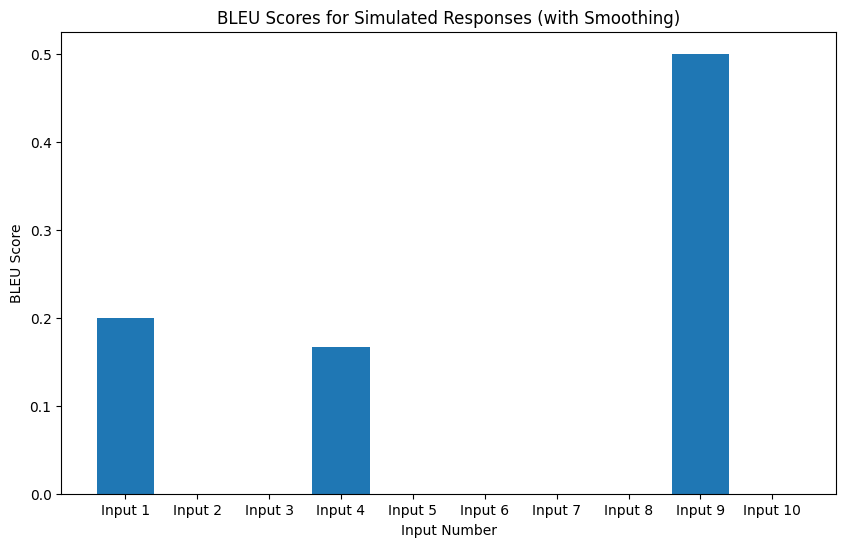

In [52]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

# Define predefined inputs, simulated responses, and reference sentences
predefined_inputs = [
    "hello?",
    "where am I?",
    "who are you?",
    "how are you doing?",
    "you're under arrest",
    "i'm just kidding",
    "where are you from?",
    "it's time for me to leave",
    "good bye",
    "quit"
]

simulated_response = [
    "hello lo . . .",
    "i m working . . .",
    "i m sorry . . .",
    "i m fine . . .",
    "i m . .",
    "you re crazy . .",
    "i m working . . .",
    "i m . . .",
    "good night . .",
    "i m sorry . ."
]

reference_sentences = [
    ["hello", "hi there", "hello there"],
    ["you are here", "you are at work", "you are in a safe place"],
    ["I am a chatbot", "I am here to assist you", "I am your virtual assistant"],
    ["I'm doing well", "I'm fine", "I'm here to help"],
    ["you are under arrest", "you are being detained", "you are in trouble"],
    ["just joking", "that was funny", "you're funny"],
    ["I am from the cloud", "I live on the internet", "I come from cyberspace"],
    ["goodbye", "farewell", "see you later"],
    ["goodbye", "good night", "take care"],
    ["quit", "exit", "see you next time"]
]

# Smoothing function to avoid zero scores for short sentences
smooth = SmoothingFunction().method1

# Calculate BLEU scores
bleu_scores = []
for simulated, references in zip(simulated_response, reference_sentences):
    # Tokenize the simulated response
    simulated_tokens = simulated.lower().split()
    # Calculate BLEU score for each simulated response with smoothing
    score = sentence_bleu([ref.split() for ref in references], simulated_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth)
    bleu_scores.append(score)

# Display BLEU scores for each response
for i, score in enumerate(bleu_scores, start=1):
    print(f"Input {i}: BLEU Score = {score:.4f}")

# Plot BLEU scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(bleu_scores) + 1), bleu_scores)
plt.xlabel("Input Number")
plt.ylabel("BLEU Score")
plt.title("BLEU Scores for Simulated Responses (with Smoothing)")
plt.xticks(range(1, len(bleu_scores) + 1), labels=[f"Input {i}" for i in range(1, len(bleu_scores) + 1)])
plt.show()


Measure similarity between chatbot responses and reference responses using cosine similarity.


Input 1: Cosine Similarity Score = 0.5739
Input 2: Cosine Similarity Score = 0.0000
Input 3: Cosine Similarity Score = 0.0000
Input 4: Cosine Similarity Score = 0.4826
Input 5: Cosine Similarity Score = 0.0000
Input 6: Cosine Similarity Score = 0.3483
Input 7: Cosine Similarity Score = 0.0000
Input 8: Cosine Similarity Score = 0.0000
Input 9: Cosine Similarity Score = 0.6602
Input 10: Cosine Similarity Score = 0.0000


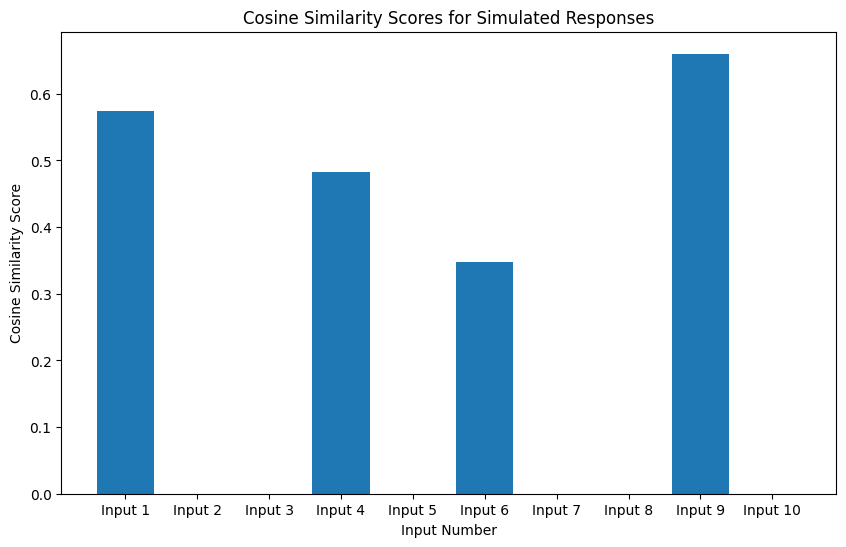

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Define the simulated responses and reference sentences as plain text
simulated_response = [
    "hello lo . . .",
    "i m working . . .",
    "i m sorry . . .",
    "i m fine . . .",
    "i m . .",
    "you re crazy . .",
    "i m working . . .",
    "i m . . .",
    "good night . .",
    "i m sorry . ."
]

reference_sentences = [
    "hello hello there",
    "you are at work",
    "I am a chatbot here to assist",
    "I'm fine here to help",
    "you are being detained",
    "that was a joke you're funny",
    "I live on the internet",
    "farewell see you later",
    "good night take care",
    "quit see you next time"
]

# Initialize TfidfVectorizer and fit it on the reference sentences and simulated responses
vectorizer = TfidfVectorizer()
all_responses = reference_sentences + simulated_response
tfidf_matrix = vectorizer.fit_transform(all_responses)

# Calculate cosine similarity for each simulated response against its corresponding reference sentence
cosine_scores = []
for i in range(len(simulated_response)):
    ref_vector = tfidf_matrix[i]  # Reference sentence vector
    sim_vector = tfidf_matrix[len(reference_sentences) + i]  # Simulated response vector
    cosine_score = cosine_similarity(ref_vector, sim_vector)[0][0]  # Calculate cosine similarity
    cosine_scores.append(cosine_score)


# Display cosine similarity scores for each response
for i, score in enumerate(cosine_scores, start=1):
    print(f"Input {i}: Cosine Similarity Score = {score:.4f}")

# Plot cosine similarity scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(cosine_scores) + 1), cosine_scores)
plt.xlabel("Input Number")
plt.ylabel("Cosine Similarity Score")
plt.title("Cosine Similarity Scores for Simulated Responses")
plt.xticks(range(1, len(cosine_scores) + 1), labels=[f"Input {i}" for i in range(1, len(cosine_scores) + 1)])
plt.show()
